# Customer Churn Reduction - Logistic Regression
In the notebook, we will use logistic regression to predict whether a customer will churn or not. 

### importing librarires 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from pandas_ml import ConfusionMatrix



In [2]:
# Read in train and test data
train_data = pd.read_csv("Train_data.csv")
test_data = pd.read_csv("Test_data.csv")

In [3]:
# change column names for ease of use and display first 5 rows
train_data.columns = train_data.columns.str.lower().str.replace(' ','_')
test_data.columns = test_data.columns.str.lower().str.replace(' ','_')

In [4]:
print(" number of rows and columns in train data ",train_data.shape)

 number of rows and columns in train data  (3333, 21)


In [5]:
print(" number of rows and columns in test data ",test_data.shape)
    

 number of rows and columns in test data  (1667, 21)


In [6]:
train_data.describe()
train_data.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [7]:
#removing variables which not helpfull in churn reduction. Using these variables dosn't make sense.
#for training data
train_data = train_data.drop(['state','area_code','phone_number'], axis = 1)
test_data = test_data.drop(['state','area_code','phone_number'], axis = 1)

In [8]:
# checking for missing values in train
train_data.isnull().sum()

account_length                   0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [9]:
# checking for missing values in test dataset
test_data.isnull().sum()

account_length                   0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

##### There are no missing values in train and test data.

Now looking at target variable.
churn: This is the target variable. Churn is defined as whether the customer leaves the services or not. churn = True means customer left ,churn = false means customer stays

Text(0.5,0,'Customer churn')

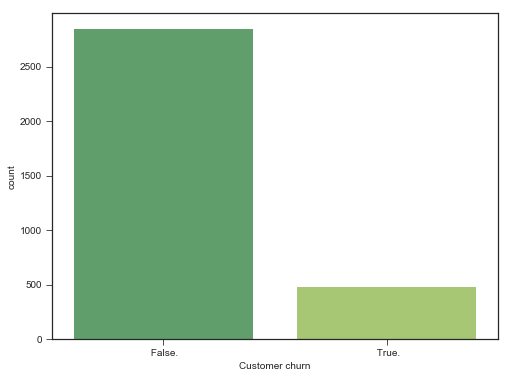

In [10]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train_data.churn,palette='summer')
plt.xlabel('Customer churn')


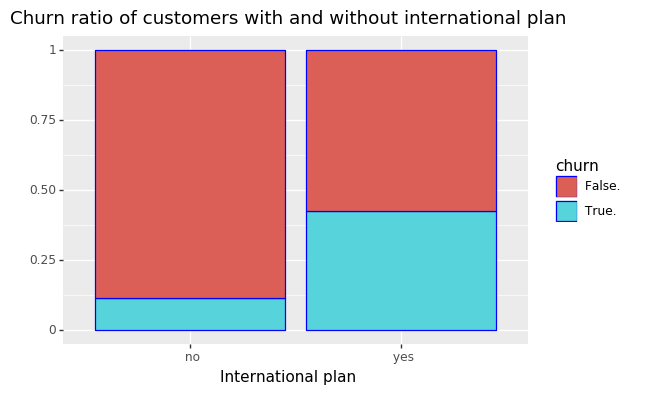

<ggplot: (-9223371887803894142)>

In [11]:
# churn ratio of customers with and without internation plan
ggplot(train_data) + \
    aes('international_plan', fill = 'churn') +\
    geom_bar(position = "fill", color= 'blue') + labs(x = "International plan", y = "") + \
    ggtitle("Churn ratio of customers with and without international plan") + \
    theme(figure_size=(6, 4))

#### Customers with international plan are churning out more as compare to domestic customers. 

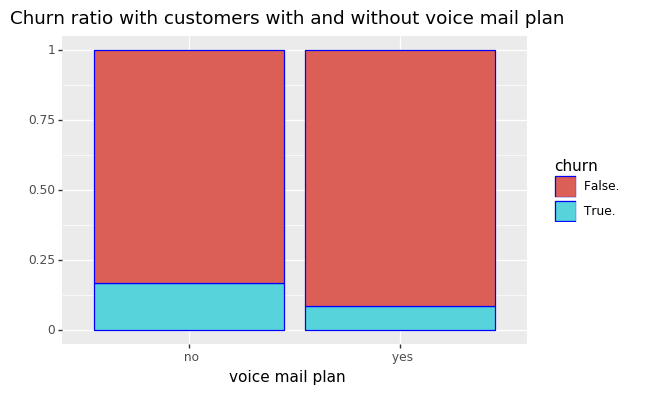

<ggplot: (-9223371887803842216)>

In [12]:
# churn ratio of customers with voice_mail_plan
ggplot(train_data) + \
    aes('voice_mail_plan', fill = 'churn') +\
    geom_bar(position = "fill", color = 'blue') + \
    labs(x =  "voice mail plan", y = "") + \
    ggtitle("Churn ratio with customers with and without voice mail plan") + \
    theme(figure_size=(6, 4))

#### Customers without voice mail plan are churning out more as compare to customers with voice mail plan.

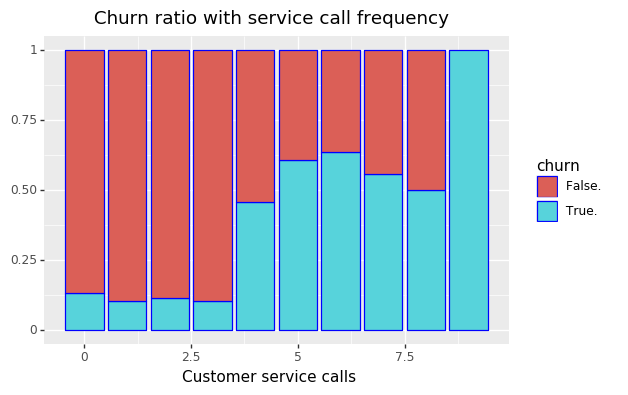

<ggplot: (-9223371887803824303)>

In [13]:
# # churn ratio of customers with respect to service calls
ggplot(train_data) + \
    aes('number_customer_service_calls', fill = 'churn') +\
    geom_bar(position = "fill", color = 'blue') + \
    labs(x = "Customer service calls", y = "")  + \
    ggtitle(" Churn ratio with service call frequency") + \
    theme(figure_size=(6, 4))

#### customers with higher service calls ie > 3 are churning out more.

### 3. Correlation matrix for continous predictors

In [14]:
churn_corr = train_data.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

churn_corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '90px', 'font-size': '10pt'})\
    .set_caption("Correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
account_length,1,-0.0046,0.0062,0.038,0.0062,-0.0068,0.019,-0.0067,-0.009,-0.013,-0.009,0.0095,0.021,0.0095,-0.0038
number_vmail_messages,-0.0046,1,0.00078,-0.0095,0.00078,0.018,-0.0059,0.018,0.0077,0.0071,0.0077,0.0029,0.014,0.0029,-0.013
total_day_minutes,0.0062,0.00078,1,0.0068,1,0.007,0.016,0.007,0.0043,0.023,0.0043,-0.01,0.008,-0.01,-0.013
total_day_calls,0.038,-0.0095,0.0068,1,0.0068,-0.021,0.0065,-0.021,0.023,-0.02,0.023,0.022,0.0046,0.022,-0.019
total_day_charge,0.0062,0.00078,1,0.0068,1,0.007,0.016,0.007,0.0043,0.023,0.0043,-0.01,0.008,-0.01,-0.013
total_eve_minutes,-0.0068,0.018,0.007,-0.021,0.007,1,-0.011,1,-0.013,0.0076,-0.013,-0.011,0.0025,-0.011,-0.013
total_eve_calls,0.019,-0.0059,0.016,0.0065,0.016,-0.011,1,-0.011,-0.0021,0.0077,-0.0021,0.0087,0.017,0.0087,0.0024
total_eve_charge,-0.0067,0.018,0.007,-0.021,0.007,1,-0.011,1,-0.013,0.0076,-0.013,-0.011,0.0025,-0.011,-0.013
total_night_minutes,-0.009,0.0077,0.0043,0.023,0.0043,-0.013,-0.0021,-0.013,1,0.011,1,-0.015,-0.012,-0.015,-0.0093
total_night_calls,-0.013,0.0071,0.023,-0.02,0.023,0.0076,0.0077,0.0076,0.011,1,0.011,-0.014,0.0003,-0.014,-0.013


### From corrplot we can see that dataset consist of multicollinearity
1. total.day.minutes and total.day.charge are highly collinear
2. total.eve.minutes and total.eve.charge are highly collinear
3. total.night.minutes and total.night.charge are highly collinear
4. total.intl.minutes and total.intl.charge are highly collinear

Multi-collinearity voilates the assumption of logistic regression. So we will be removing one of these predictors 
from the model. 

### 4. Exploring continous predictors

In [15]:
# function for exploring distributions by continuous predictors with there summary stats
def countPred_eda(train_data, variableName, targetVariable):
    print(train_data[variableName].describe())
    return ggplot(train_data) + \
    aes(targetVariable, variableName, fill = targetVariable) + geom_boxplot(alpha = .8, outlier_color = "green") + \
    labs(x =  targetVariable, y = variableName) + \
    ggtitle("Churn ratio with "+ variableName) + \
    theme(figure_size=(6, 4))
     
    

count    3333.000000
mean      179.775098
std        54.467389
min         0.000000
25%       143.700000
50%       179.400000
75%       216.400000
max       350.800000
Name: total_day_minutes, dtype: float64


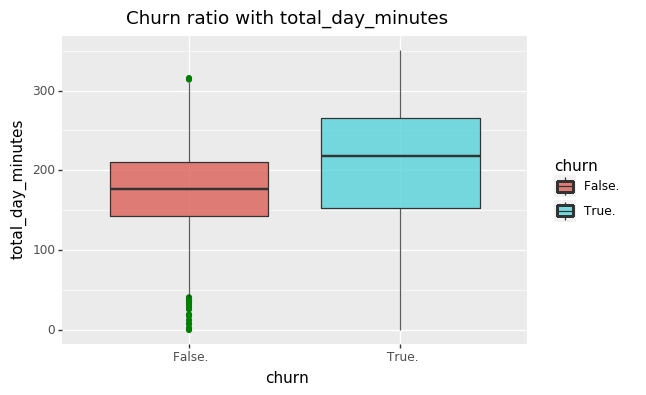

<ggplot: (-9223371887803824282)>

In [16]:
# --- total_day_minutes --- #
countPred_eda(train_data,'total_day_minutes','churn')

#### It is evident from above plot that churn rate is higher when count of total_day_minute is higher

count    3333.000000
mean      100.435644
std        20.069084
min         0.000000
25%        87.000000
50%       101.000000
75%       114.000000
max       165.000000
Name: total_day_calls, dtype: float64


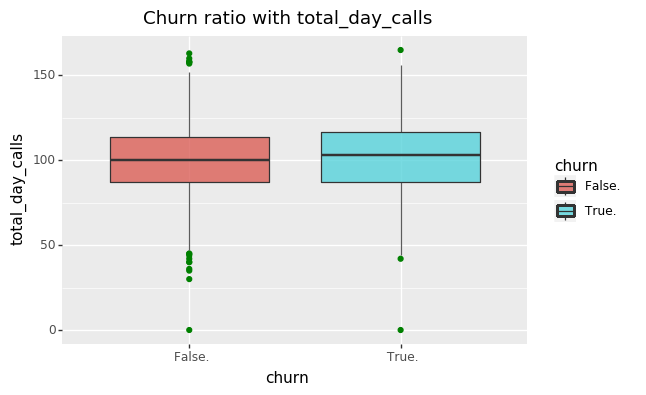

<ggplot: (149052182213)>

In [17]:
# --- total_day_calls ---- #
countPred_eda(train_data,'total_day_calls','churn')

count    3333.000000
mean       30.562307
std         9.259435
min         0.000000
25%        24.430000
50%        30.500000
75%        36.790000
max        59.640000
Name: total_day_charge, dtype: float64


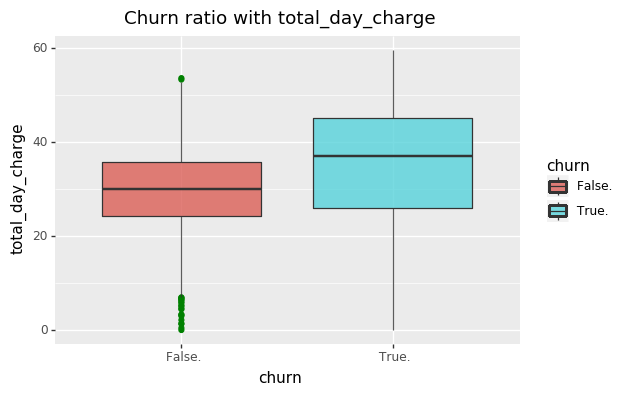

<ggplot: (149052216005)>

In [18]:
# --- total_day_charge --- #
countPred_eda(train_data,'total_day_charge','churn')


count    3333.000000
mean      200.980348
std        50.713844
min         0.000000
25%       166.600000
50%       201.400000
75%       235.300000
max       363.700000
Name: total_eve_minutes, dtype: float64


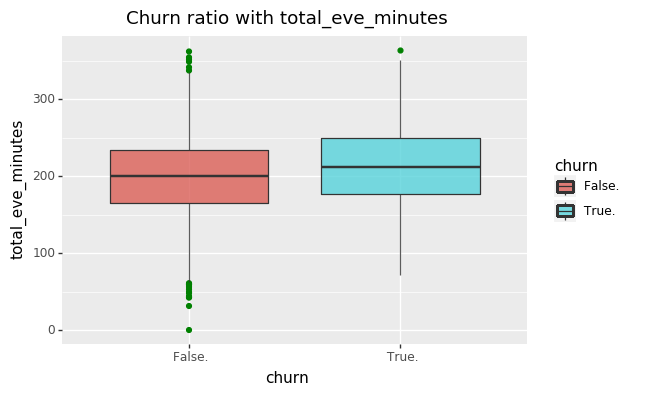

<ggplot: (-9223371887802643063)>

In [19]:
# --- total_eve_minutes --- #
countPred_eda(train_data,'total_eve_minutes','churn')


count    3333.000000
mean      100.114311
std        19.922625
min         0.000000
25%        87.000000
50%       100.000000
75%       114.000000
max       170.000000
Name: total_eve_calls, dtype: float64


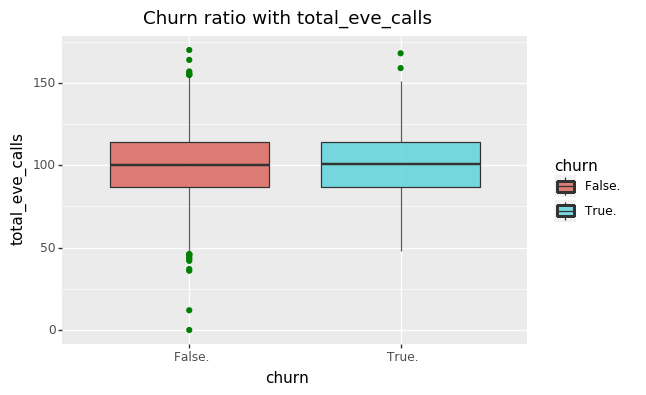

<ggplot: (-9223371887802500727)>

In [20]:
# --- total_eve_calls --- #
countPred_eda(train_data,'total_eve_calls','churn')


count    3333.000000
mean       17.083540
std         4.310668
min         0.000000
25%        14.160000
50%        17.120000
75%        20.000000
max        30.910000
Name: total_eve_charge, dtype: float64


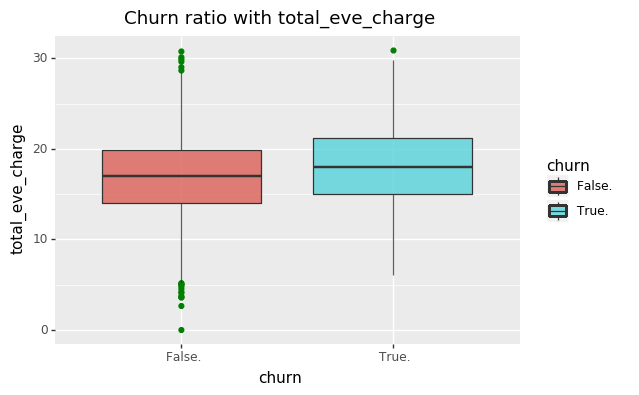

<ggplot: (149052314772)>

In [21]:
# --- total_eve_charge --- #
countPred_eda(train_data,'total_eve_charge','churn')


count    3333.000000
mean      200.872037
std        50.573847
min        23.200000
25%       167.000000
50%       201.200000
75%       235.300000
max       395.000000
Name: total_night_minutes, dtype: float64


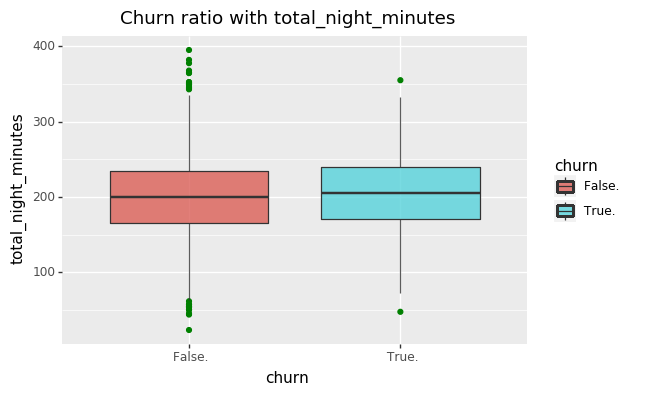

<ggplot: (-9223371887802474808)>

In [22]:
# --- total_night_minutes --- #
countPred_eda(train_data,'total_night_minutes','churn')


count    3333.000000
mean      100.107711
std        19.568609
min        33.000000
25%        87.000000
50%       100.000000
75%       113.000000
max       175.000000
Name: total_night_calls, dtype: float64


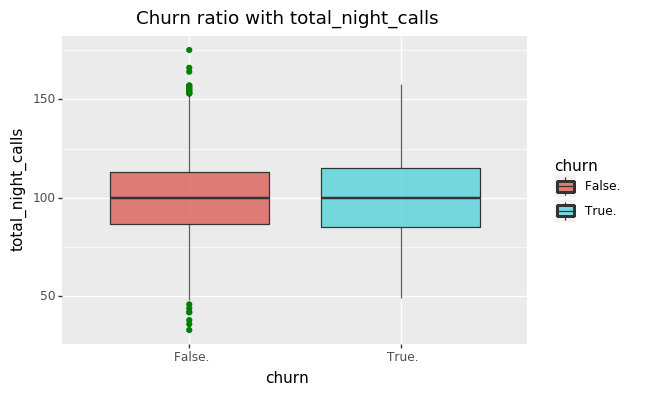

<ggplot: (-9223371887802393705)>

In [23]:
# --- total_night_calls --- #
countPred_eda(train_data,'total_night_calls','churn')


count    3333.000000
mean        9.039325
std         2.275873
min         1.040000
25%         7.520000
50%         9.050000
75%        10.590000
max        17.770000
Name: total_night_charge, dtype: float64


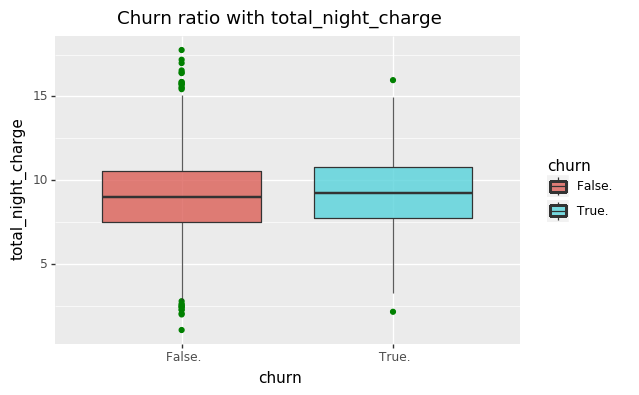

<ggplot: (149052413851)>

In [24]:
# --- total_night_charge --- #
countPred_eda(train_data,'total_night_charge','churn')


count    3333.000000
mean       10.237294
std         2.791840
min         0.000000
25%         8.500000
50%        10.300000
75%        12.100000
max        20.000000
Name: total_intl_minutes, dtype: float64


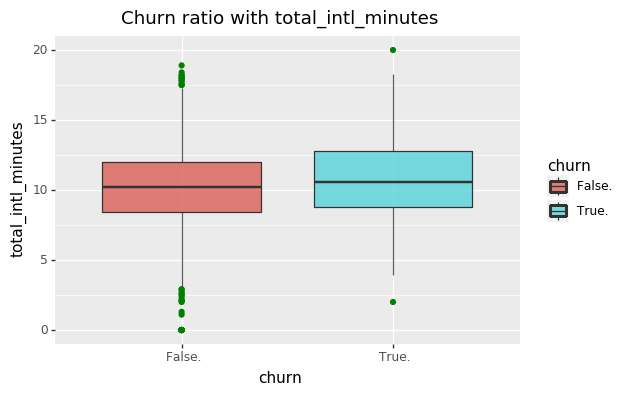

<ggplot: (-9223371887802344234)>

In [25]:
# --- total_intl_minutes --- #
countPred_eda(train_data,'total_intl_minutes','churn')


count    3333.000000
mean        4.479448
std         2.461214
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: total_intl_calls, dtype: float64


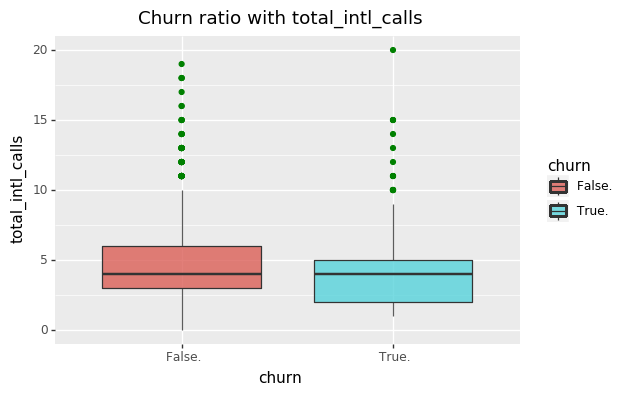

<ggplot: (149052434173)>

In [26]:
# --- total_intl_calls --- #
countPred_eda(train_data,'total_intl_calls','churn')


count    3333.000000
mean        2.764581
std         0.753773
min         0.000000
25%         2.300000
50%         2.780000
75%         3.270000
max         5.400000
Name: total_intl_charge, dtype: float64


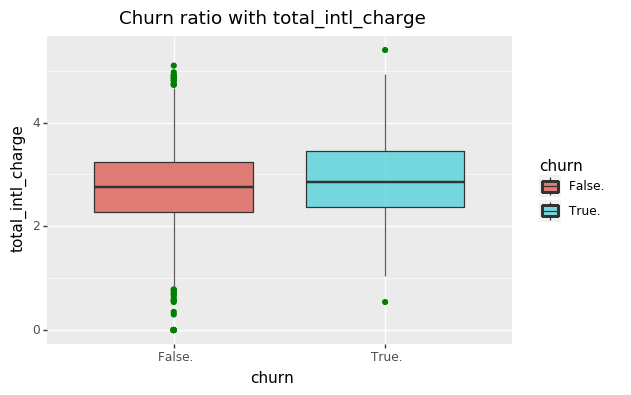

<ggplot: (-9223371887802393817)>

In [27]:
# --- total_intl_charge --- #
countPred_eda(train_data,'total_intl_charge','churn')

count    3333.000000
mean        1.562856
std         1.315491
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: number_customer_service_calls, dtype: float64


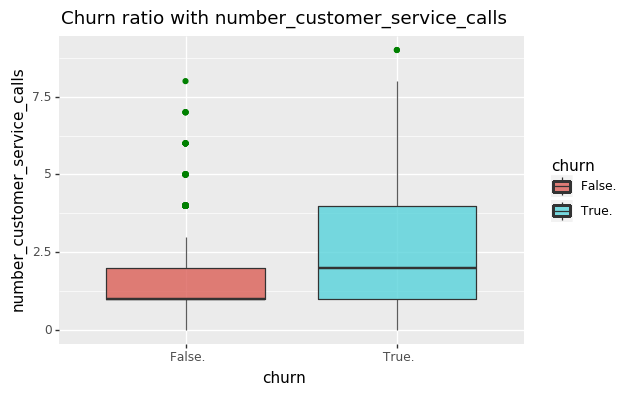

<ggplot: (149052284708)>

In [28]:
# --- number_customer_service_calls --- #
countPred_eda(train_data,'number_customer_service_calls','churn')

In [29]:
# Removing highly collinear variables from train and test
train_data = train_data.drop(['total_day_charge','total_eve_charge','total_night_charge', 'total_intl_charge'], axis = 1)
test_data = test_data.drop(['total_day_charge','total_eve_charge','total_night_charge', 'total_intl_charge'], axis = 1)


In [30]:
# encoding target variables 
le = LabelEncoder()
# for train data
train_data.churn = le.fit_transform(train_data.churn)
# for test data
test_data.churn = le.fit_transform(test_data.churn)

In [31]:
# Encoding categorical variables
# for train data
train_data.international_plan = le.fit_transform(train_data.international_plan)
train_data.voice_mail_plan = le.fit_transform(train_data.voice_mail_plan)

# for test data
test_data.international_plan = le.fit_transform(test_data.international_plan)
test_data.voice_mail_plan = le.fit_transform(test_data.voice_mail_plan)


In [32]:
test_data.head()


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,101,0,0,0,70.9,123,211.9,73,236.0,73,10.6,3,3,0
1,137,0,0,0,223.6,86,244.8,139,94.2,81,9.5,7,0,0
2,103,0,1,29,294.7,95,237.3,105,300.3,127,13.7,6,1,0
3,99,0,0,0,216.8,123,126.4,88,220.6,82,15.7,2,1,0
4,108,0,0,0,197.4,78,124.0,101,204.5,107,7.7,4,2,0


In [33]:
train_data.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [34]:
# selecting predictors
train_feature_space = train_data.iloc[:,train_data.columns != 'churn']
# selecting target class
target_class = train_data.iloc[:,train_data.columns == 'churn']


In [35]:
# creating training and validation set
training_set, validation_set, train_taget, validation_target = train_test_split(train_feature_space,
                                                                    target_class,
                                                                    test_size = 0.30, 
                                                                    random_state = 456)

# Cleaning test sets to avoid future warning messages
train_taget = train_taget.values.ravel() 
validation_target = validation_target.values.ravel() 


In [36]:
# logistic regression classifier 
classifier_logit_default = LogisticRegression(random_state=456)


In [37]:
classifier_logit_default.fit(training_set, train_taget)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=456, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
# Predicting the validation set results 
validation_prediction = classifier_logit_default.predict(validation_set)

In [39]:
# confusion matrix for validation set
validation_logit_crosstb = pd.crosstab(index = validation_target,
                           columns = validation_prediction)
validation_logit_crosstb = validation_logit_crosstb.rename(columns= {0: 'False', 1: 'True'})
validation_logit_crosstb.index = ['False', 'True']
validation_logit_crosstb.columns.name = 'n = 1000'

In [40]:
validation_logit_crosstb

n = 1000,False,True
False,825,25
True,118,32


In [41]:
#classification report on validation set
target_names =[0,1]

validation_report = classification_report(validation_prediction, validation_target,  target_names )
print(validation_report)

             precision    recall  f1-score   support

          0       0.97      0.87      0.92       943
          1       0.21      0.56      0.31        57

avg / total       0.93      0.86      0.89      1000



In [42]:
mean_accuracy_validation = classifier_logit_default.score(validation_set, validation_target)
print(' Mean accuracy on validation set',mean_accuracy_validation)

 Mean accuracy on validation set 0.857


In [43]:
# calculating test error rate on validation set
test_error_rate = 1 - mean_accuracy_validation
print(' Test error rate on validation set',test_error_rate)

 Test error rate on validation set 0.143


From the confusion matrix we can see that high accuracy of model is due to disproportionate number of non-churn 
customers predicted correctly. The This model is working great for identifing non churning customer but performing poorly for 
churning customers. We will tune the model to increase accuracy on churning customer. 

In [44]:
# model 2
classifier_logit_2 = LogisticRegression(class_weight='balanced') 


param = {'C':[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5,2,3]} 
#rs_cv = RandomizedSearchCV(estimator=classifier_logit_2, cv = 10,
                            #n_iter = 100, 
                           #param_distributions=param, random_state=1234) 
rs_cv = GridSearchCV(estimator=classifier_logit_2, cv = 10,param_grid=param) 

rs_cv.fit(training_set,train_taget) 

print('Best parameter :{} Best score :{}'.format(rs_cv.best_params_,rs_cv.best_score_))


Best parameter :{'C': 3} Best score :0.7711101585940848


In [45]:
classifier_logit_2.set_params(C = 3)

LogisticRegression(C=3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
classifier_logit_2.fit(training_set, train_taget)

LogisticRegression(C=3, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [47]:
validation_prediction_tuned = classifier_logit_2.predict(validation_set)

In [48]:
# confusion matrix for validation set
validation_logit_crosstb1 = pd.crosstab(index = validation_target,
                           columns = validation_prediction_tuned)
validation_logit_crosstb1 = validation_logit_crosstb1.rename(columns= {0: 'False', 1: 'True'})
validation_logit_crosstb1.index = ['False', 'True']
validation_logit_crosstb1.columns.name = 'n = 1000'

In [49]:
validation_logit_crosstb1

n = 1000,False,True
False,641,209
True,35,115


In [50]:
#classification report on validation set with hypertuning
target_names =[0,1]

validation_report_tuning = classification_report(validation_prediction_tuned, validation_target,  target_names )
print(validation_report_tuning)

             precision    recall  f1-score   support

          0       0.75      0.95      0.84       676
          1       0.77      0.35      0.49       324

avg / total       0.76      0.76      0.73      1000



### Prediction and performance on test data

Model classifier_logit_2 was selected.

In [51]:
# test set
test_set = test_data.iloc[:,test_data.columns != 'churn']
# selecting target class for test set
test_set_target = test_data.iloc[:,test_data.columns == 'churn']


# Predicting the test set results
test_prediction = classifier_logit_2.predict(test_set)

In [52]:
# confusion matrix for validation set
test_logit_crosstb = pd.crosstab(index = test_data.churn,
                           columns = test_prediction)
test_logit_crosstb = test_logit_crosstb.rename(columns= {0: 'False', 1: 'True'})
test_logit_crosstb.index = ['False', 'True']
test_logit_crosstb.columns.name = 'n = onservation'

In [53]:
cm = ConfusionMatrix(test_data.churn, test_prediction)


In [61]:
cm


Predicted  False  True  __all__
Actual                         
False       1096   347     1443
True          39   185      224
__all__     1135   532     1667

In [60]:
cm.print_stats()

population: 1667
P: 224
N: 1443
PositiveTest: 532
NegativeTest: 1135
TP: 185
TN: 1096
FP: 347
FN: 39
TPR: 0.825892857143
TNR: 0.759528759529
PPV: 0.347744360902
NPV: 0.96563876652
FPR: 0.240471240471
FDR: 0.652255639098
FNR: 0.174107142857
ACC: 0.768446310738
F1_score: 0.489417989418
MCC: 0.428323776007
informedness: 0.585421616672
markedness: 0.313383127422
prevalence: 0.134373125375
LRP: 3.43447663648
LRN: 0.22923048097
DOR: 14.9826350403
FOR: 0.0343612334802


In [55]:
#classification report on test set with hypertuning
target_names =[0,1]

test_report_tuning = classification_report(test_prediction, test_data.churn,  target_names )
print(test_report_tuning)

             precision    recall  f1-score   support

          0       0.76      0.97      0.85      1135
          1       0.83      0.35      0.49       532

avg / total       0.78      0.77      0.74      1667



In [56]:
mean_accuracy_test = classifier_logit_2.score(test_set, test_set_target)
print(' Mean accuracy on test set',mean_accuracy_test)

 Mean accuracy on test set 0.768446310738


In [57]:
# calculating test error rate on test set
test_error_rate_testset = 1 - mean_accuracy_test
print(' Test error rate on test set',test_error_rate)

 Test error rate on test set 0.143


In [63]:
test_set_target.churn.value_counts()

0    1443
1     224
Name: churn, dtype: int64

In [65]:
# Model input and output
test_set.to_csv('inputLogisticRegressionPython.csv', encoding = 'utf-8', index = False)
pd.DataFrame(train_taget).to_csv('targetLogisticRegressionPython.csv', index = False)
pd.DataFrame(test_prediction, columns=['predictions']).to_csv('outputLogisticRegressionPython.csv')
